#Just run it all

In [1]:
!pip install pytorch-tabnet
!pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm

import xgboost

from pytorch_tabnet.tab_model import  TabNetRegressor

In [30]:
!wget https://raw.githubusercontent.com/alezakuskin/Stark_ML/Classes/Stark_data.csv

--2022-04-08 13:18:08--  https://raw.githubusercontent.com/alezakuskin/Stark_ML/Classes/Stark_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147034 (144K) [text/plain]
Saving to: ‘Stark_data.csv’

Stark_data.csv      100%[===================>] 143.59K  --.-KB/s    in 0.02s   

2022-04-08 13:18:08 (9.18 MB/s) - ‘Stark_data.csv’ saved [147034/147034]



In [3]:
def term_to_number(term):
  momentum = pd.Series()
  for i, val in enumerate(term):
    if type(val) == type(0):
      momentum.at[i] = val
    if val == 'S':
      momentum.at[i] = 0
    elif val == 'P':
      momentum.at[i] = 1
    elif val == 'D':
      momentum.at[i] = 2
    elif val == 'F':
      momentum.at[i] = 3
    elif val == 'G':
      momentum.at[i] = 4
    elif val == 'H':
      momentum.at[i] = 5
    else:
      raise NameError(f'Term symbol "{val}" is not specified')
  return momentum

def bootstrap_metric(x, 
                     y,
                    metric_fn,
                    samples_cnt=1000,
                    alpha=0.05,
                    random_state=777):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        if not isinstance(x, np.ndarray):
          x_boot = x.to_numpy()[poses]
        else:
          x_boot = x
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
            
    return b_metric

def train_and_test_regressor(models, X_train, y_train, X_test, y_test, max_epochs = 1000, patience = 50):
  X_train_save, y_train_save = X_train, y_train
  X_test_save, y_test_save = X_test, y_test
  predictions = {}
  for name, model in models.items():
    if isinstance(model, TabNetRegressor):
      X_train, X_test = X_train_save.to_numpy(), X_test_save.to_numpy()
      y_train, y_test = y_train_save.to_numpy().reshape(-1, 1), y_test_save.to_numpy().reshape(-1, 1)
    else:
      X_train, X_test = X_train_save, X_test_save
      y_train, y_test = y_train_save, y_test_save
   
    print(f"Fitting {name}")
    if isinstance(model, TabNetRegressor):
      model.fit(X_train, y_train,
                max_epochs = max_epochs,
                patience = patience
                )
    else:
      model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
      
  boot_scores = {}

  for name, y_pred in predictions.items():
      print(f"Calculating bootstrap score for {name}")
      boot_score = bootstrap_metric(y_test, 
                                      y_pred, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                                y_pred=y,
                                                                                squared = False))
      boot_scores[name] = boot_score
      
  
  results = pd.DataFrame(boot_scores)
  # cast to long format
  results = results.melt(value_vars=results.columns,
                      value_name="mse", 
                      var_name="model") 
  return results

def plot_model_comparison(results, figsize = (15, 8), y = 'mse'):
  fig, ax = plt.subplots(figsize = figsize)
  sns.boxplot(data = results, y = y, x="model", ax = ax)
  ax.set_xlabel("", size=40)
  ax.set_ylabel("MSE", size=20)
  ax.set_title("Estimators vs MSE", size=30)
  plt.show()

def test_selection(data, target, p = 0.2, low_limit = 'min', up_limit = 'max', random_state = None):
  if low_limit != 'min':
    low_limit = str(low_limit) + '%'
  if up_limit != 'max':
    up_limit = str(up_limit) + '%'
  
  stats = target.describe()
  target_range = target[(target >= stats[low_limit]) & (target <= stats[up_limit])]
  target_selected = target_range.sample(frac = p, random_state = random_state)
  data_selected = data.loc[target_selected.index.to_list()]

  return data_selected, target_selected

# Data preprocessing

In [38]:
data = pd.read_csv('Stark_data.csv',
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [39]:
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])


data_shift = data[np.isnan(data['d (A)']) == False]
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])

#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
data_shift = data_shift.sort_values(by=['Z number'])
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 351
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [40]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [41]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


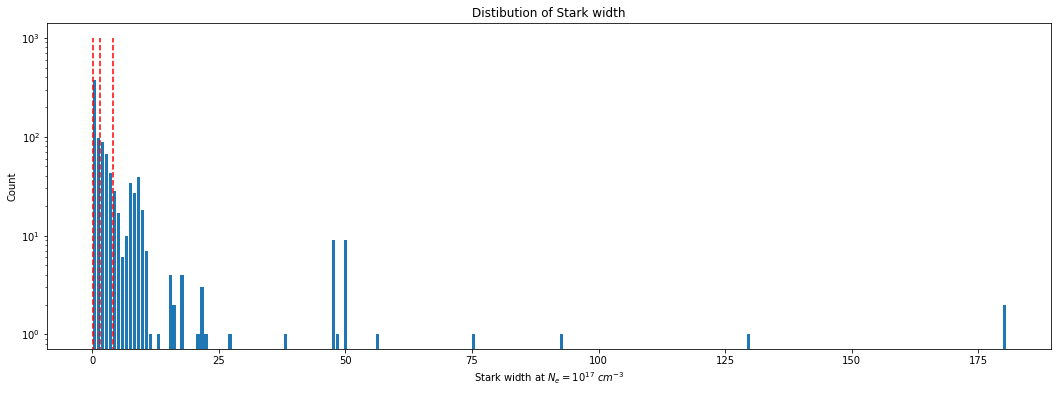

In [42]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [43]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


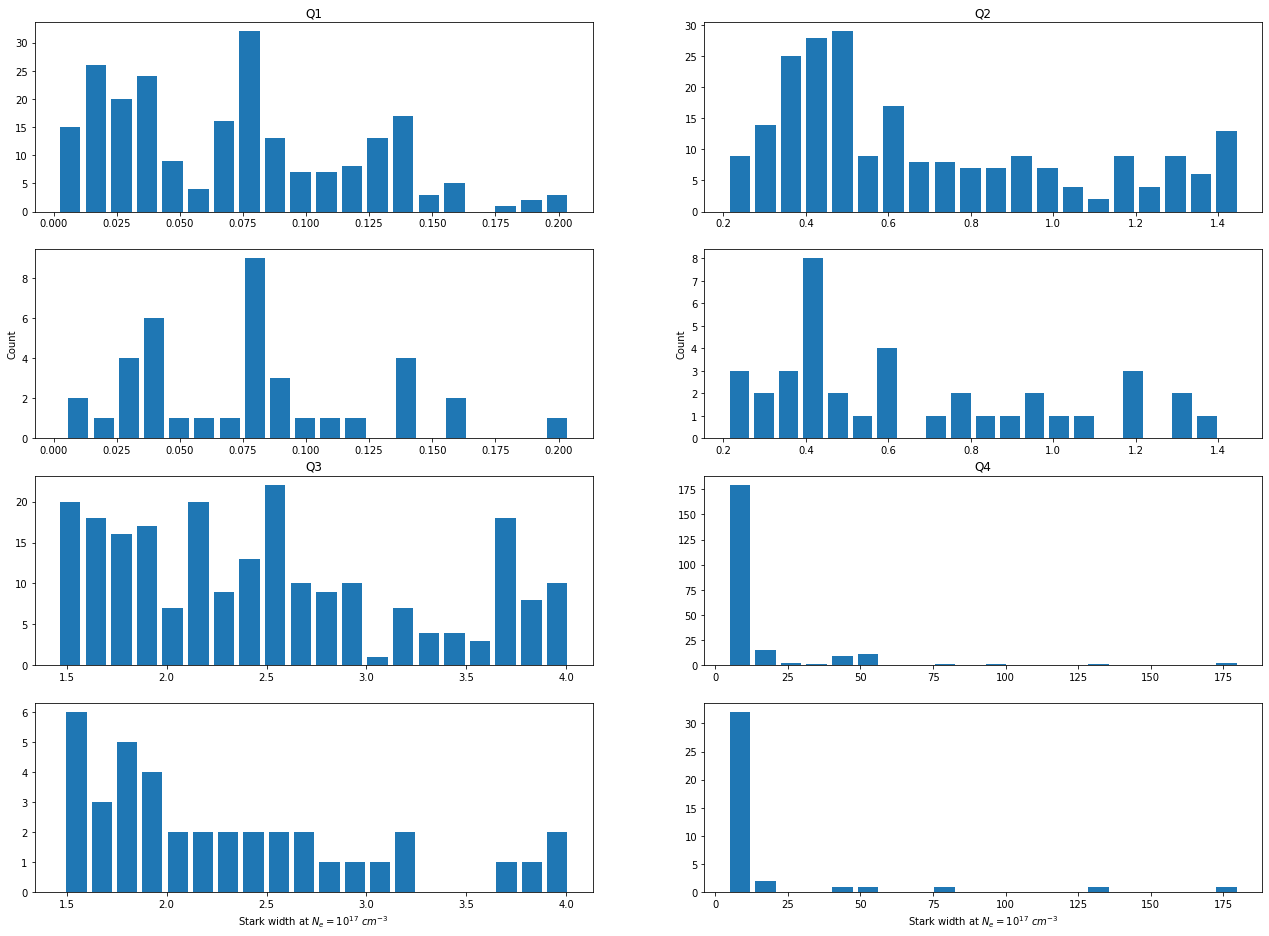

In [44]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [45]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

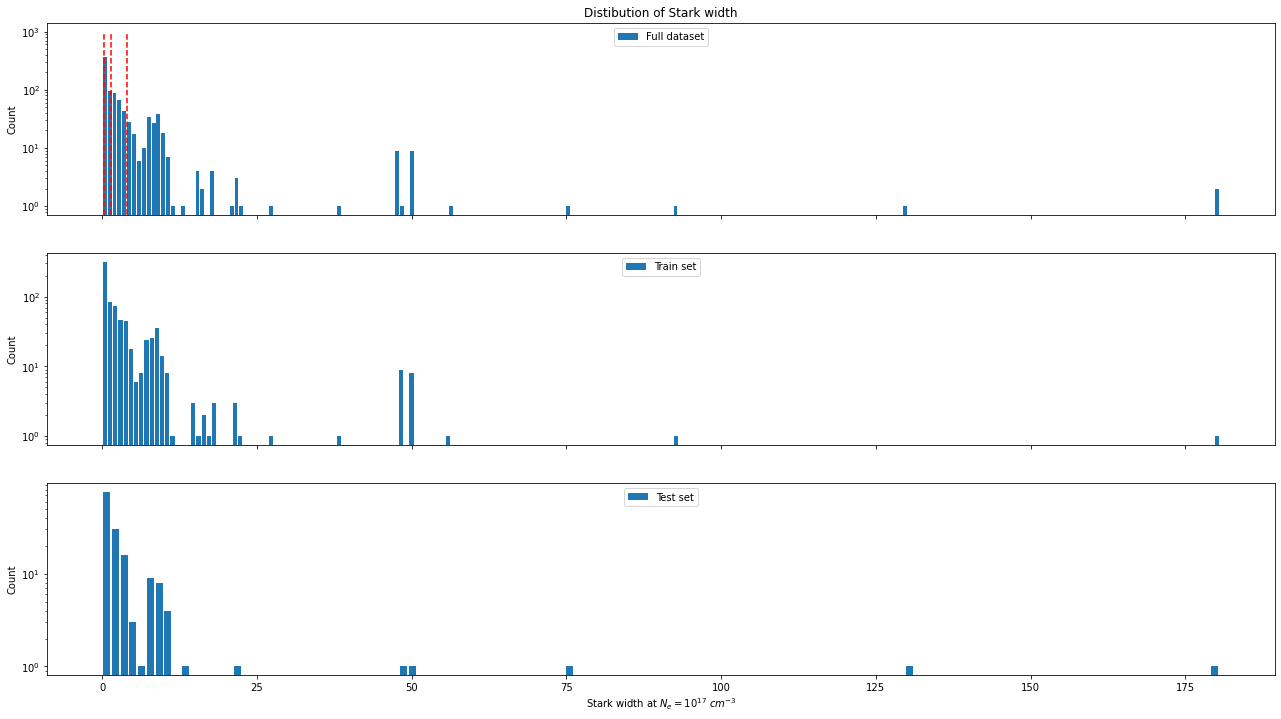

In [46]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

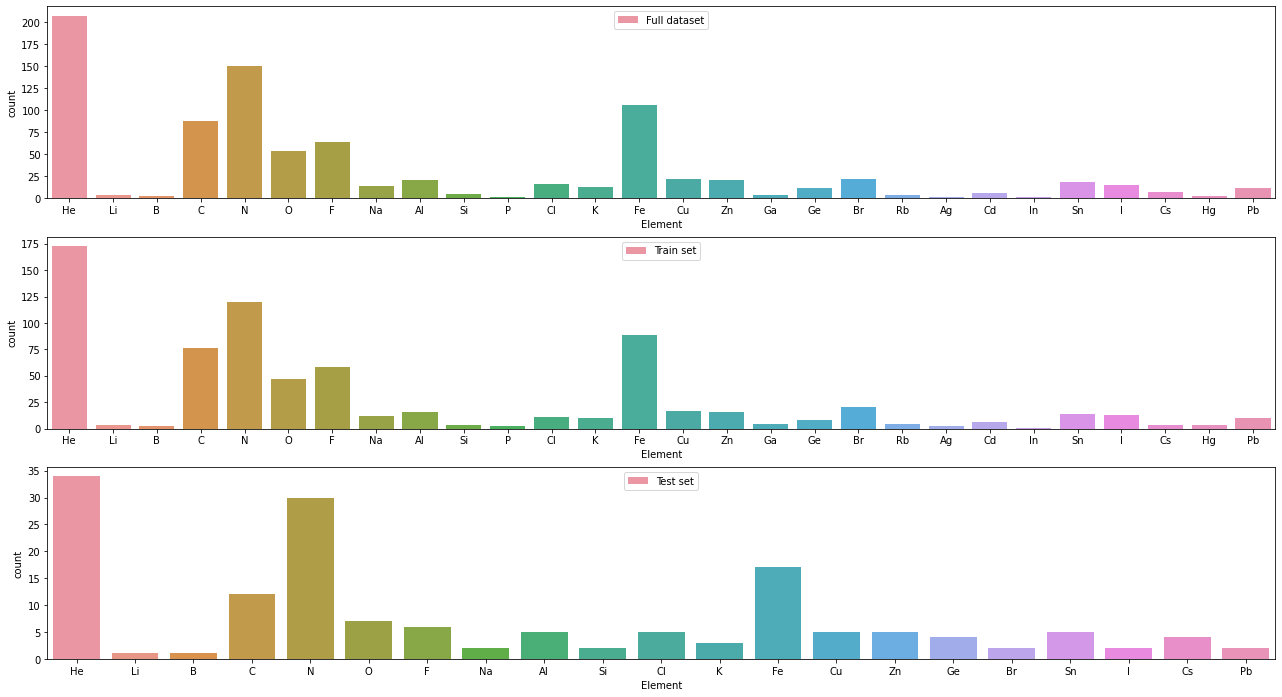

In [47]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [48]:
#Assigning proper variables
XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test


#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

#Classes definitions

In [ ]:
class BaseModel:

    def __init__(self, params):
        self.predictions = None

        # Save all hyperparameters which are optimized
        self.params = params

        # Model has to be set by the concrete model
        self.model = None

    def fit(self, X, y, X_val=None, y_val=None):
        self.model.fit(X, y)

    def predict(self, X):
        self.predictions = self.model.predict(X)
        return self.predictions

    def save_model_and_predictions(self, y_true, filename_extension=""):
        self.save_predictions(y_true, filename_extension)
        self.save_model(filename_extension)

    def clone(self):
        return self.__class__(self.params)

    @classmethod
    def define_trial_parameters(cls, trial):
        raise NotImplementedError("This method has to be implemented by the sub class")

    '''
        Private functions
    '''

    def save_model(self, filename_extension=""):
        print('lll')

    def save_predictions(self, y_true, filename_extension=""):
       print('kkk')


class KNN(BaseModel):

    def __init__(self, params):
        super().__init__(params)

        self.model = KNeighborsRegressor(n_neighbors = params['n_neighbors'],
                                         leaf_size = params['leaf_size'],
                                         p = params['p'],
                                         weights = params['weights'],
                                         algorithm = params['algorithm'],
                                         n_jobs=-1)

        self.params = params
        
    def fit(self, X, y, X_val=None, y_val=None):
        
        return super().fit(X, y, X_val, y_val)

    @classmethod
    def define_trial_parameters(cls, trial, params):
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", params['n_neighbors'][0], params['n_neighbors'][1]),
            'weights' : trial.suggest_categorical('weights', params['weights']),
            'algorithm' : trial.suggest_categorical('algorithm', params['algorithm']),
            'leaf_size' : trial.suggest_int("leaf_size", params['leaf_size'][0], params['leaf_size'][1]),
            'p' : trial.suggest_float('p', params['p'][0], params['p'][1])
        }
        return params


class RandomForest(BaseModel):

    def __init__(self, params):
        super().__init__(params)

        self.model = RandomForestRegressor(n_estimators = params['n_estimators'],
                                           max_depth = params['max_depth'],
                                           min_samples_split = params['min_samples_split'],
                                           min_samples_leaf = params['min_samples_leaf'],
                                           n_jobs = -1)
        
        self.params = params

    @classmethod
    def define_trial_parameters(cls, trial, params):
        params = {
            'n_estimators': trial.suggest_int('n_estimatoprs', params['n_estimators'][0], params['n_estimators'][1], log = True),
            'max_depth': trial.suggest_int('max_depth', params['max_depth'][0], params['max_depth'][1], log = False),
            'min_samples_split': trial.suggest_int('min_samples_split', params['min_samples_split'][0], params['min_samples_split'][1], log = False),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', params['min_samples_leaf'][0], params['min_samples_leaf'][1], log = False)
        }
        return params



class Gradient_Boosting(BaseModel):

    def __init__(self, params):
        super().__init__(params)

        self.model = GradientBoostingRegressor(
            learning_rate = params['learning_rate'],
            min_samples_split = params['min_samples_split'],
            min_samples_leaf = params['min_samples_leaf'],
            max_depth = params['max_depth']
        )

        self.params = params
    
    @classmethod
    def define_trial_parameters(cls, trial, params):
        params = {
            'learning_rate' : trial.suggest_float('learning_rate', params['learning_rate'][0], params['learning_rate'][1]),
            'min_samples_split': trial.suggest_int('min_samples_split', params['min_samples_split'][0], params['min_samples_split'][1], log = False),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', params['min_samples_leaf'][0], params['min_samples_leaf'][1], log = False),
            'max_depth': trial.suggest_int('max_depth', params['max_depth'][0], params['max_depth'][1], log = False)
        }
        return params


class XGBoost(BaseModel):

    def __init__(self, params):
        super().__init__(params)

        self.model = xgboost.XGBRegressor(
            learning_rate = params['learning_rate'],
            min_child_weight = params['min_chils_weight'],
            max_depth = params['max_depth']
        )

        self.params = params

    @classmethod
    def define_trial_parameters(cls, trial, params):
        params = {
            'min_child_weight': trial.suggest_int('min_child_weight', params['min_child_weight'][0], params['min_child_weight'][1], log = False),
            'max_depth' : trial.suggest_int('max_depth', params['max_depth'][0], params['max_depth'][1], log = False),
            'learning_rate' : trial.suggest_float('learning_rate', params['learning_rate'][0], params['learning_rate'][1])
        }


class TabNet(BaseModel):

    def __init__(self, params):
        super().__init__(params)

        self.model = TabNetRegressor(

        )

    self.params = params

    @classmethod
    def define_trial_parameters(cls, trial, params):
        params = {
            'n_d' :
            'n_steps' :
            'gamma'
        }

In [ ]:
class Objective(object):
    def __init__(self, model_name, X, y, params):
        self.model_name = model_name

        # Save the trainings data
        self.X = X
        self.y = y
        self.params = params

        
    def __call__(self, trial):
        # Define hyperparameters to optimize
        trial_params = self.model_name.define_trial_parameters(trial, self.params)

        # Create model
        model = self.model_name(trial_params)

        #model.fit(self.X, self.y)
        score = 0
        # Cross validate the chosen hyperparameters

        kf = KFold(self.params['nfold'])
        for train, test in kf.split(self.X):
            model.fit(self.X.iloc[train, :], self.y.iloc[train])
            score += mean_squared_error(self.y.iloc[test], model.predict(self.X.iloc[test, :]), squared = True)

        score /= self.params['nfold']

        #Sklearn cross_val_score doesn't work because it need sklearn model
        '''score = -cross_val_score(estimator = model,
                                X = self.X, y = self.y,
                                cv = params['nfold'],
                                scoring = 'neg_root_mean_squared_error')'''

        return score


def main(X, y, model_name, params, n_trials = 100):
    print("Start hyperparameter optimization")
    
    study = optuna.create_study()
    study.optimize(Objective(model_name, X, y, params), n_trials)
    print("Best parameters:", study.best_trial.params)

    return study

In [ ]:
params = {
    'n_neighbors' : [2, 71],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [2, 50],
    'p' : [1., 2.],
    'nfold' : 5
    }
model_name = KNN
main(X = XW_train, y = YW_train, model_name = model_name, params = params, n_trials = 200)

[I 2022-04-05 16:53:15,088] A new study created in memory with name: no-name-3238e289-b628-41a9-aba9-6dd49aecf344


Start hyperparameter optimization


[I 2022-04-05 16:53:15,672] Trial 0 finished with value: 123.1835960310149 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 33, 'p': 1.7736573145605083}. Best is trial 0 with value: 123.1835960310149.
[I 2022-04-05 16:53:16,444] Trial 1 finished with value: 121.72461116476586 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 2, 'p': 1.21831909489445}. Best is trial 1 with value: 121.72461116476586.
[I 2022-04-05 16:53:17,737] Trial 2 finished with value: 133.94519193974375 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 45, 'p': 1.2540941539705066}. Best is trial 1 with value: 121.72461116476586.
[I 2022-04-05 16:53:18,389] Trial 3 finished with value: 122.49731885597961 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 24, 'p': 1.761410830869751}. Best is trial 1 with value: 121.72461116476586.
[I 20

Best parameters: {'n_neighbors': 22, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 45, 'p': 1.226346323536395}


# Old vs New

Fitting Old
Fitting Optuna_root_distance
Fitting Optuna_squared_distance
Fitting Optuna_squared_allfree
Calculating bootstrap score for Old
Calculating bootstrap score for Optuna_root_distance
Calculating bootstrap score for Optuna_squared_distance
Calculating bootstrap score for Optuna_squared_allfree


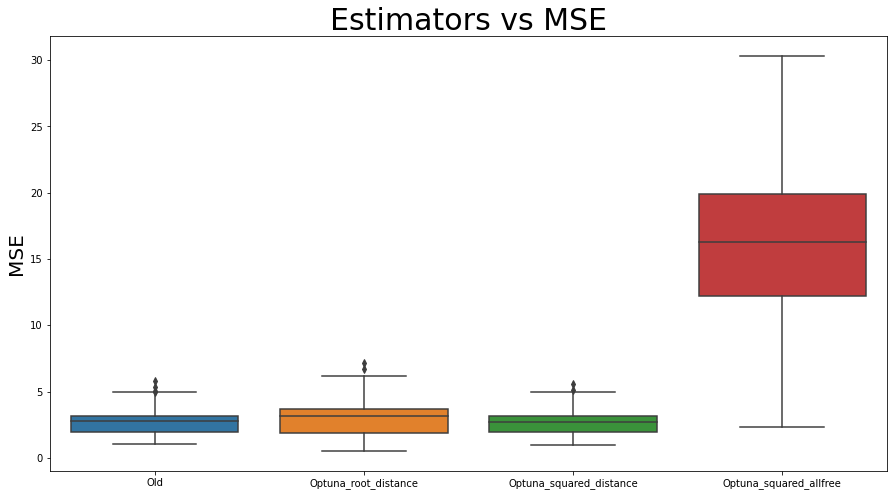

In [ ]:
models = {}
models['Old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
'''models['Optuna_root_uniform'] = KNeighborsRegressor(n_neighbors = 22,
                                    weights = 'uniform',
                                    leaf_size = 18,
                                    p = 1.0919836588721228,
                                    n_jobs = -1)'''
models['Optuna_root_distance'] = KNeighborsRegressor(n_neighbors = 23,
                                    weights = 'distance',
                                    leaf_size = 11,
                                    p = 1.0327240654553769,
                                    n_jobs = -1)
'''models['Optuna_squared_uniform'] = KNeighborsRegressor(n_neighbors = 23,
                                    weights = 'uniform',
                                    leaf_size = 16,
                                    p = 1.1724159170672794,
                                    n_jobs = -1)'''
models['Optuna_squared_distance'] = KNeighborsRegressor(n_neighbors = 70,
                                    weights = 'distance',
                                    leaf_size = 13,
                                    p = 1.0106462392953968,
                                    n_jobs = -1)
models['Optuna_squared_allfree'] = KNeighborsRegressor(n_neighbors = 22,
                                    weights = 'uniform',
                                    algorithm = 'kd_tree',
                                    leaf_size = 45,
                                    p = 1.226346323536395,
                                    n_jobs = -1)

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)

In [ ]:
params = {
    'n_estimators' : [10, 1000],
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5
    }
model_name = RandomForest
main(X = XW_train, y = YW_train, model_name = model_name, params = params, n_trials = 200)

[I 2022-04-05 17:23:01,364] A new study created in memory with name: no-name-ff371f0d-2b70-4ad0-b4f6-79b40b59ed4e


Start hyperparameter optimization


[I 2022-04-05 17:23:13,294] Trial 0 finished with value: 190.54322028627706 and parameters: {'n_estimatoprs': 705, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 190.54322028627706.
[I 2022-04-05 17:23:20,255] Trial 1 finished with value: 159.0590852912731 and parameters: {'n_estimatoprs': 557, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 1 with value: 159.0590852912731.
[I 2022-04-05 17:23:30,286] Trial 2 finished with value: 190.74879979958897 and parameters: {'n_estimatoprs': 681, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 159.0590852912731.
[I 2022-04-05 17:23:32,030] Trial 3 finished with value: 167.70041465255957 and parameters: {'n_estimatoprs': 113, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 159.0590852912731.
[I 2022-04-05 17:23:33,102] Trial 4 finished with value: 187.80001529296237 and parameters: 

Best parameters: {'n_estimatoprs': 34, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 10}


Fitting Old
Fitting New
Calculating bootstrap score for Old
Calculating bootstrap score for New


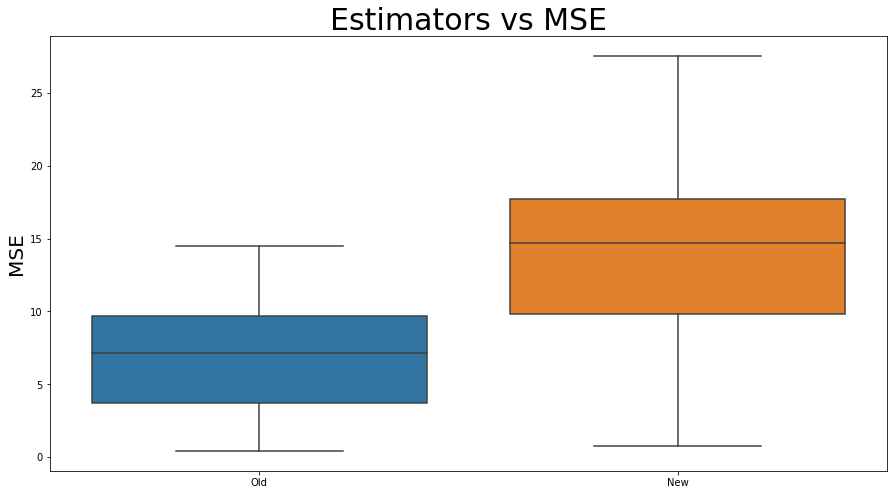

In [ ]:
models = {}
models['Old'] = RandomForestRegressor(n_estimators=500,
                                           max_depth = 25,
                                           min_samples_leaf = 2,
                                           min_samples_split = 2,
                                           n_jobs = -1)
models['New'] = RandomForestRegressor(n_estimators= 34,
                                      max_depth= 20,
                                      min_samples_split= 8,
                                      min_samples_leaf= 10)

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)

# Crossval test

In [ ]:
kf = KFold(5, shuffle = False)
train = kf.split(XW_train)

handmade_model = KNN({'n_neighbors' : 30})

handmade_score = 0

for tr, val in train:
    handmade_model.fit(XW_train.iloc[tr, :], YW_train.iloc[tr])
    #print(mean_squared_error(YW_train.iloc[val], handmade_model.predict(XW_train.iloc[val, :])))
    handmade_score += mean_squared_error(YW_train.iloc[val], handmade_model.predict(XW_train.iloc[val, :]), squared = False)

handmade_score /= 5

sklearn_score = -cross_val_score(estimator = KNeighborsRegressor(n_neighbors=30),
                                X = XW_train, y = YW_train,
                                cv = 5,
                                scoring = 'neg_root_mean_squared_error')

print(f'Handmade function gives: {handmade_score:.2f}')
print(f'Sklearn CV score: {sklearn_score.mean():.2f}')

Handmade function gives: 9.13
Sklearn CV score: 9.13
